# Introduction
### Defining problem
This is one of the challenges from Why R? hackathon in 2020. As the name says it was first challenge which should prepare participants to the rest of the competition. Below we can see an original content of the task. For more information you can check the source https://github.com/WhyR2020/hackathon.

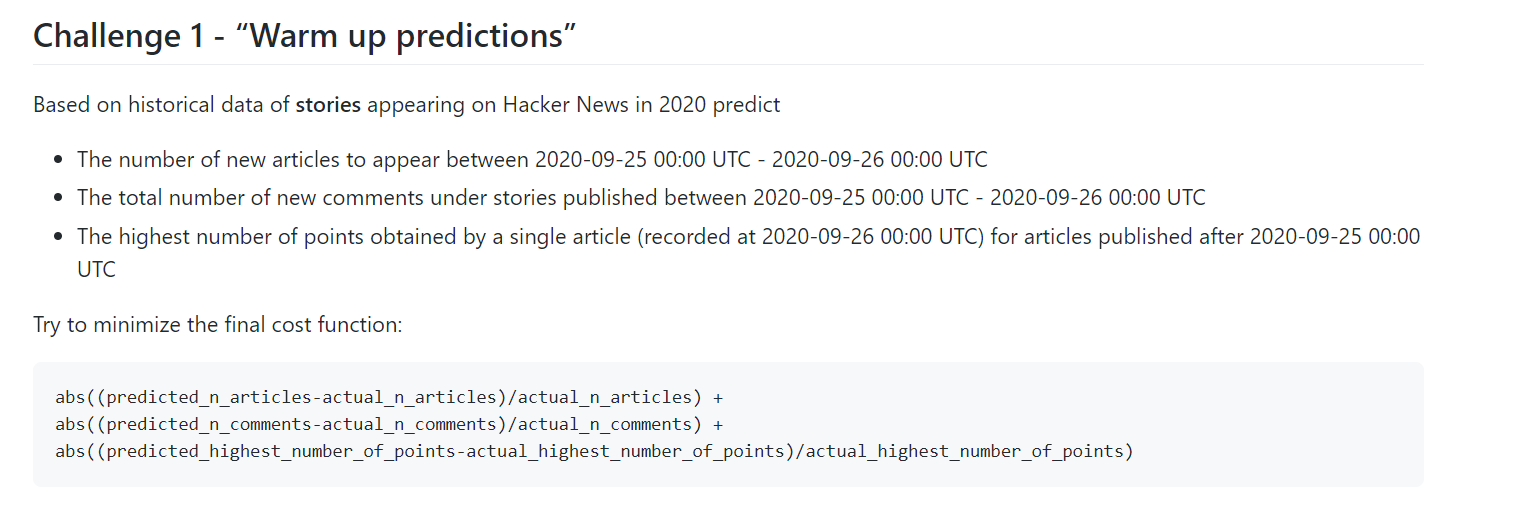

So in other words it will be regression problem and most certainly time series analysis. 

We assume the real data were downloaded 12.10.2020 which was some days after the actual prediction day. After 25th there could be also some likes or comments published under posts from that day but there was no option to catch that so we 
overlook this inaccuracy.

Unfortunately, I couldn't be on this hackathon but my friends won one of the challenges. The motivation to do it comes from my scientific club of mathematical statistics "GAUSS" on Wrocław University of Science and Technology. It was task for self-learning and improving our machine learning skills. As it is known there is always more fun in the group. There was one additional benefit from this. We could improve our presentation skills because all results was presented in from of the group. 

It was also a competition for us because the one who gain the best result get the fame and glory :D <br>

As it is my first contact with time series I decided to use SARIMA model as it is more complex than normal ARIMA but still in my range of experience. Naturally the main problem should be solved in R, but we omit that restriction so we could code in the python.

## Solving problem schedule:
 - Prepare the data
     - Download  data from github repository of Why R?
     - Create entire data frame
 - Data preprocessing
     - organize  selected data by formatting, cleaning and sampling from it.
     - Handling missing values 
     - Explanatory data analysis
 - Time series analysis
     - visualizations
     - Dickey-Fuller test
 - Data transformation
     - Making time series stationary
 - Fitting SARIMA
 - Plotting result
 - Scraping test data
 - Conclusion

In [46]:
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import statsmodels
import pmdarima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

import requests

import visualization as vis
warnings.filterwarnings('ignore')

In [2]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (10, 8)

# Data preparation

First of all we download data from hackathon's site then let's take a closer look. I put the description of columns below.

by - author of the post <br>
descendants - the number of comments under certain post. <br>
id - unique post's id <br>
kids - id of the main comments under the post. <br>
time - the day of publishing.<br>
title - title of post<br>
type - the type of post (mainly story)<br>
url - the source of texts<br>

In [3]:
df = pd.read_json('data/articles.json')
df.head()

by descendants          id  \
0     [todsacerdoti]       [607]  [24563698]   
1  [themodelplumber]       [126]  [24562850]   
2              [luu]        [27]  [24553085]   
3        [pseudolus]        [56]  [24553369]   
4         [jeanyang]        [24]  [24561119]   

                                                kids  score  \
0  [24563821, 24563987, 24565829, 24564488, 24563...  [711]   
1  [24563705, 24563838, 24563276, 24563478, 24565...  [310]   
2  [24563230, 24562887, 24562049, 24564895, 24562...  [227]   
3  [24563122, 24565813, 24562283, 24562375, 24563...   [94]   
4  [24561495, 24562538, 24565366, 24564334, 24561...   [87]   

                    time                                              title  \
0  [2020-09-23 08:38:33]  [Firefox usage is down 85% despite Mozilla's t...   
1  [2020-09-23 06:04:45]  [How to say no, for the people pleaser who alw...   
2  [2020-09-22 13:04:22]                                       [Small Tech]   
3  [2020-09-22 13:47:02]  [You Talkin’ to Me? The Unruly History of New ...   
4  [2020-09-23 01:13:58]    [Catch Breaking Changes by Diffing API Traffic]   

      type                                                url  
0  [story]              [http://calpaterson.com/mozilla.html]  
1  [story]  [https://www.npr.org/2020/09/15/913207918/how-...  
2  [story]  [https://scattered-thoughts.net/writing/small-...  
3  [story]    [https://literaryreview.co.uk/tawk-of-the-town]  
4  [story]  [https://www.akitasoftware.com/blog/2020/9/22/...

The data were stored in json files and as we can see they are a bit messy, probably in the purpose of competition. Lets clean them to desired state.

In [4]:
def data_cleaning(df, strip_list, int_list):
    # extracting strings from lists
    for i in strip_list:
        df[i] = df[i].str.join('')

    # turning strings of numeric columns to int
    for i in int_list:
        df[i] = df[[i]].agg(lambda row: int(row[0][0]), axis=1)

    # Turning to date time
    df.time = pd.to_datetime(df.time)
    df.type = df.type.astype('category')
    return df

In [5]:
# text columns
columns_to_strip = ['by', 'time', 'title', 'type', 'url']
# numeric columns
columns_to_int = ['descendants', 'id', 'score']

# cleaning data
df = data_cleaning(df, columns_to_strip, columns_to_int)
df.head()

by  descendants        id  \
0     todsacerdoti          607  24563698   
1  themodelplumber          126  24562850   
2              luu           27  24553085   
3        pseudolus           56  24553369   
4         jeanyang           24  24561119   

                                                kids  score  \
0  [24563821, 24563987, 24565829, 24564488, 24563...    711   
1  [24563705, 24563838, 24563276, 24563478, 24565...    310   
2  [24563230, 24562887, 24562049, 24564895, 24562...    227   
3  [24563122, 24565813, 24562283, 24562375, 24563...     94   
4  [24561495, 24562538, 24565366, 24564334, 24561...     87   

                 time                                              title  \
0 2020-09-23 08:38:33  Firefox usage is down 85% despite Mozilla's to...   
1 2020-09-23 06:04:45  How to say no, for the people pleaser who alwa...   
2 2020-09-22 13:04:22                                         Small Tech   
3 2020-09-22 13:47:02  You Talkin’ to Me? The Unruly History of New Y...   
4 2020-09-23 01:13:58      Catch Breaking Changes by Diffing API Traffic   

    type                                                url  
0  story                http://calpaterson.com/mozilla.html  
1  story  https://www.npr.org/2020/09/15/913207918/how-t...  
2  story  https://scattered-thoughts.net/writing/small-t...  
3  story      https://literaryreview.co.uk/tawk-of-the-town  
4  story  https://www.akitasoftware.com/blog/2020/9/22/f...

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25577 entries, 0 to 25576
Data columns (total 9 columns):
by             25577 non-null object
descendants    25577 non-null int64
id             25577 non-null int64
kids           25577 non-null object
score          25577 non-null int64
time           25577 non-null datetime64[ns]
title          25577 non-null object
type           25577 non-null category
url            25577 non-null object
dtypes: category(1), datetime64[ns](1), int64(3), object(4)
memory usage: 1.6+ MB


Now it's look far more better. Let's take a short look on some statistics.

In [7]:
df.describe()

descendants            id         score
count  25577.000000  2.557700e+04  25577.000000
mean      86.513899  2.310809e+07    153.437698
std      119.409818  8.202950e+05    190.811060
min        0.000000  2.172906e+07      2.000000
25%       16.000000  2.239692e+07     46.000000
50%       48.000000  2.306292e+07     95.000000
75%      109.000000  2.381546e+07    188.000000
max     2248.000000  2.456533e+07   3816.000000

In [8]:
df.describe(include=['O'])

by   kids                                              title  \
count       25577  25577                                              25577   
unique      10144  25552                                              25413   
top     pseudolus     {}  Almost everything on computers is perceptually...   
freq          339     26                                                  4   

          url  
count   25577  
unique  24549  
top            
freq      901

As we can see the descendant column which is very important to us has big standard deviation. It can be problem because we want this feature to be stationary which means in simple words that it doesn't change drastically. As we can easily observe the coefficient of variation for this column is greater than 100%. It indicates that we will surely transform it. The same goes to the number of likes which is score column. From the string columns we can see that some of the posts were doubled, or they don't provide url. Let's inspect that further.

####  Missing values handling

Observations without urls are another type of posts or more precisely popular ask from the users. As we can predict such popularity under asks is quite rare so I think that it was very small probability that such posts occur in the 25th but likes are likes and it is hard to tell that it disrupts model performance. Let's keep them.

In [9]:
df[df.url == '']

by  descendants        id  \
26          temp141516           55  24560119   
102              MrXOR          453  24436135   
106            aumakua           94  24459155   
133             sage76          151  24460286   
335      throwawayt856          173  23404900   
...                ...          ...       ...   
25511      veggiepulse          291  23426574   
25512        luddite99          184  23414896   
25515            quotz           61  23427186   
25529             4444           25  23427516   
25530  anonymous_smile           64  23427110   

                                                    kids  score  \
26     [24563371, 24562589, 24560480, 24563362, 24564...     71   
102    [24440127, 24437624, 24440095, 24440491, 24442...    212   
106    [24463309, 24466192, 24463836, 24463017, 24463...    107   
133    [24460498, 24460480, 24460433, 24460410, 24462...    155   
335    [23409051, 23405898, 23408292, 23408149, 23406...    181   
...                                                  ...    ...   
25511  [23427342, 23426879, 23427953, 23427881, 23426...    271   
25512  [23427906, 23415189, 23428292, 23415546, 23415...    165   
25515  [23428882, 23429476, 23432721, 23429960, 23436...    163   
25529  [23427645, 23444861, 23438618, 23438156, 23429...     60   
25530  [23429917, 23429519, 23429791, 23428989, 23429...     51   

                     time                                              title  \
26    2020-09-22 23:25:04                  Ask HN: So I Hired a Homeless Guy   
102   2020-09-10 22:16:46               Ask HN: What is your favorite motto?   
106   2020-09-13 09:37:46    Ask HN: Where to meet non-technical cofounders?   
133   2020-09-13 14:06:55  Ask HN: Should I quit the field of software de...   
335   2020-06-03 17:59:55  Ask HN: How do you organise your files and fol...   
...                   ...                                                ...   
25511 2020-06-05 11:27:23  Ask HN: Are my expectations on code quality an...   
25512 2020-06-04 12:43:15  Ask HN: Have you ever gone without a computer ...   
25515 2020-06-05 13:01:21  Ask HN: Which Coursera courses/specializations...   
25529 2020-06-05 14:03:11  Ask HN: Which is that site which gives learnin...   
25530 2020-06-05 12:48:44  Ask HN: How to disagree with the rest of manag...   

        type url  
26     story      
102    story      
106    story      
133    story      
335    story      
...      ...  ..  
25511  story      
25512  story      
25515  story      
25529  story      
25530  story      

[901 rows x 9 columns]

Type column doesn't contain nans what is nice. We can see that the last observation was from 23.09.2020 which is two days before prediction day so we have to predict in to days straight.

In [10]:
df.type.value_counts()

story    25577
Name: type, dtype: int64

In [11]:
df.time.max()

Timestamp('2020-09-23 12:39:53')

The number of unique ids is the same as the number of observations which suggest that every post is unique.

In [12]:
np.unique(df.id).shape

(25577,)

What is interesting there was article titled with single letter X. I checked in case it could be missing value.

In [13]:
df[df.title.str.len() < 3]

by  descendants        id  \
1619  boffinism          128  23256756   

                                                   kids  score  \
1619  [23257224, 23257029, 23257244, 23257551, 23257...    896   

                    time title   type                     url  
1619 2020-05-21 12:24:11     X  story  https://xkcd.com/2309/

### Exploratory data analysis

We can see that score and descendants are highly correlated which is quite obvious because the more post has likes the more comments.

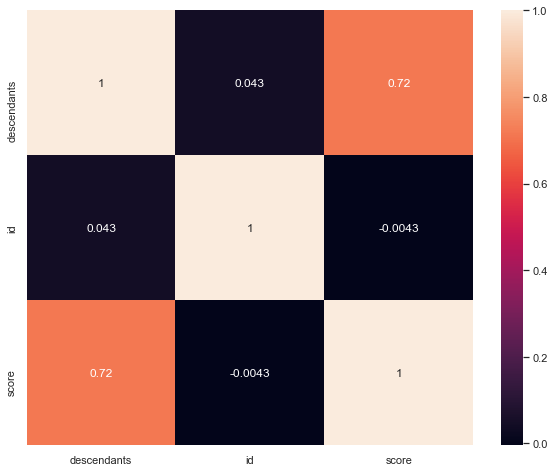

In [14]:
sns.heatmap(df.corr(), annot=True);

As we can see the distribution of both is very skewed with high kurtosis what is useful because we can take log of data and expected that they can be more normal.

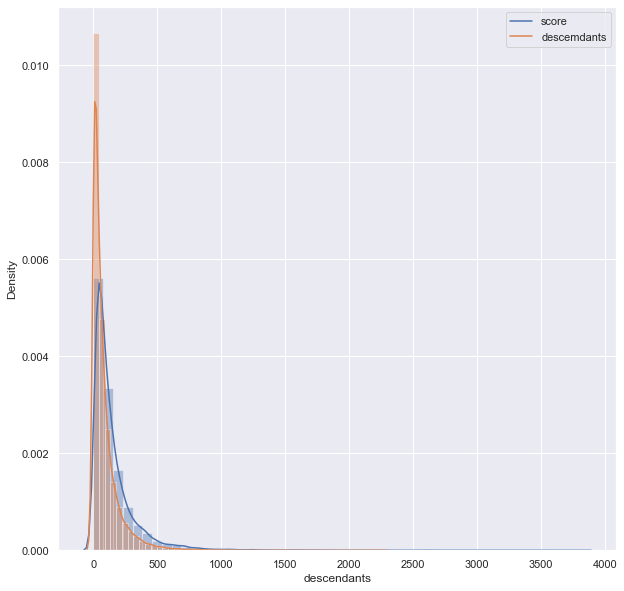

In [15]:
sns.set()
fig, ax = plt.subplots(figsize=(10,10))
sns.distplot(df['score'], ax=ax);
sns.distplot(df['descendants'], ax=ax);
ax.legend(['score', 'descemdants']);

There is one strange observation. There are 200 observations in which the number of descendants, so comments are different from the number of elements in kids column (which are ids of those comments). This number should be the same and it was very strange. As I dive deeper into this problem I discover in another json file that it indicates deleted comments. We don't know when they were deleted and which true value od descendants should be so we assumed that it provides real value.

In [16]:
df[df.descendants < df.kids.apply(len)]

by  descendants        id  \
23         programd            1  24551043   
122         dnetesn            3  24451504   
347           Tomte            1  23388897   
372        joeyespo            3  23407975   
525     whoishiring          334  23379194   
...             ...          ...       ...   
25351  pavelegorkin            1  23446061   
25360          ghgr            1  23448863   
25447         fanf2            4  23441502   
25457      samizdis            1  23440157   
25547       1cvmask            1  23423921   

                                                    kids  score  \
23                                  [24566004, 24565729]     19   
122             [24459236, 24459839, 24464441, 24453324]     19   
347                       [23405528, 23405450, 23407242]     37   
372             [23408283, 23420565, 23408204, 23408237]     21   
525    [23379950, 23380027, 23385196, 23385428, 23389...    163   
...                                                  ...    ...   
25351                               [23446966, 23446679]     14   
25360                               [23449064, 23449557]     18   
25447  [23442067, 23442150, 23442076, 23442130, 23445...     29   
25457                     [23441627, 23441505, 23441436]      8   
25547                               [23426274, 23426275]     30   

                     time                                              title  \
23    2020-09-22 07:07:28  Search historic newspaper photos using Newspap...   
122   2020-09-12 12:51:03                   Jellyfish: Toxic but fascinating   
347   2020-06-02 10:25:44                        Truth in Advertising (2016)   
372   2020-06-03 22:02:52  Google Faces $5B Lawsuit for Collecting User I...   
525   2020-06-01 17:01:03         Ask HN: Who wants to be hired? (June 2020)   
...                   ...                                                ...   
25351 2020-06-07 11:39:16       How To Write fanfiction: 10 ficwriting rules   
25360 2020-06-07 19:17:14  Brave Browser is hijacking links and inserting...   
25447 2020-06-06 21:03:03                              USB-C is still a mess   
25457 2020-06-06 18:11:00  Science Fiction Writers of America: Statement ...   
25547 2020-06-05 02:59:56  France, Germany back European cloud computing ...   

        type                                                url  
23     story         https://news-navigator.labs.loc.gov/search  
122    story  http://oceans.nautil.us/feature/615/toxic-but-...  
347    story                           http://sagehill.net/tia/  
372    story  https://www.news18.com/news/tech/google-faces-...  
525    story                                                     
...      ...                                                ...  
25351  story  https://readandwrite.today/essay/10-ficwriting...  
25360  story  https://mobile.twitter.com/cryptonator1337/sta...  
25447  story  https://www.androidauthority.com/state-of-usb-...  
25457  story  https://www.sfwa.org/2020/06/04/a-statement-fr...  
25547  story  https://www.reuters.com/article/us-europe-tech...  

[210 rows x 9 columns]

After the above we can finally extract our three useful time series.

In [17]:
# The number of likes through the day
score_series = df.score
score_series.index = df.time
score_series = score_series.resample('d').max()

# The number of comments through the day
comments_series = df.descendants
comments_series.index = df.time
comments_series = comments_series.resample('d').sum()

# The number of posts through the day
articles_series = df.score.resample('d').count()
articles_series.name = 'articles'

#  Time series analysis

## Visualisations

Up to this point we extract needed time series. Let's take a look on them.

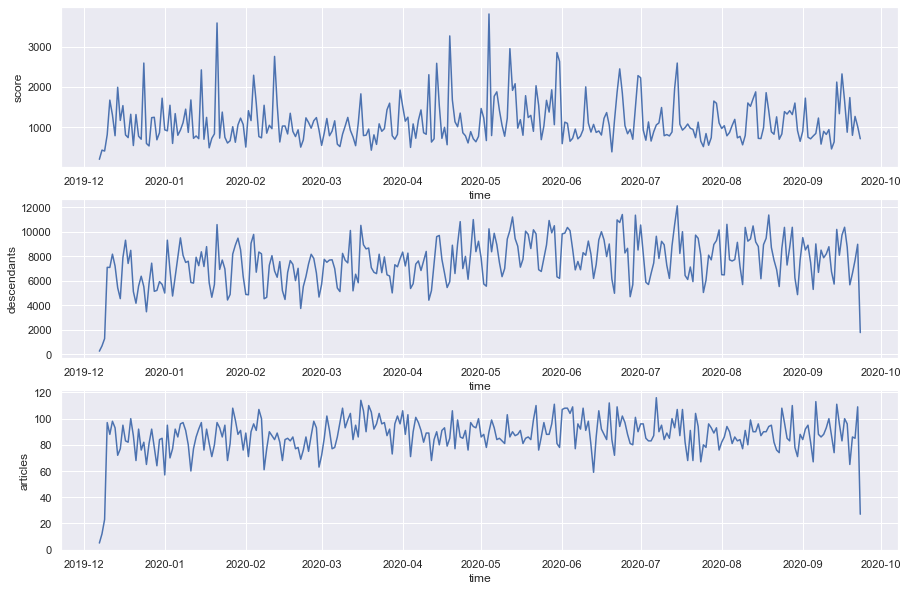

In [18]:
vis.drawing_time_series(score_series, comments_series, articles_series)

And in the one plot.

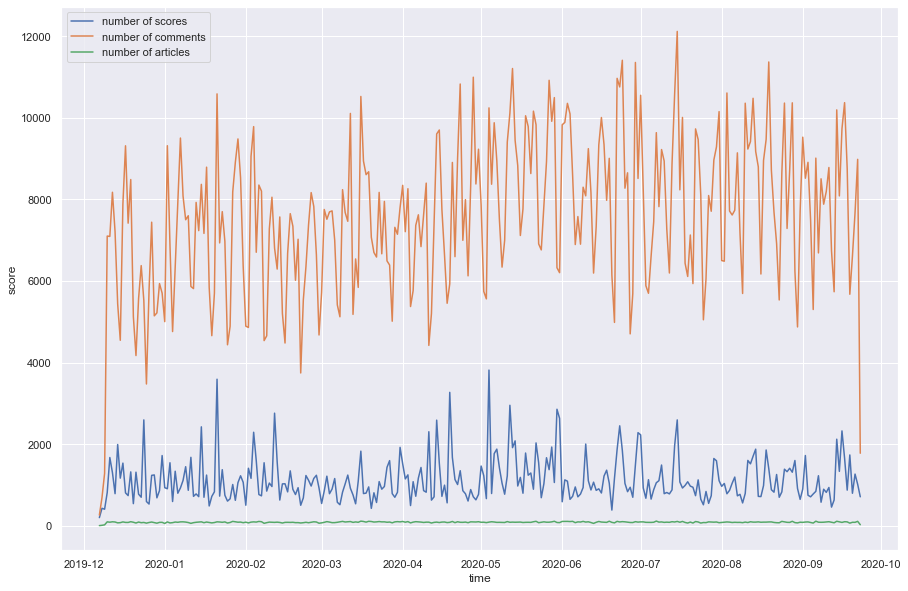

In [19]:
fig, ax = plt.subplots(figsize=(15, 10))
g = sns.lineplot(x=score_series.index, y=score_series, ax=ax, label='number of scores')
h = sns.lineplot(x=comments_series.index, y=comments_series, ax=ax, label='number of comments')
i = sns.lineplot(x=articles_series.index, y=articles_series, ax=ax, label='number of articles')

As we can note in each case some of the first observations stand off from the rest. It could be the some of the first days of the website. The same goes to the last observation which clearly is to low. As we could see from the max of time column, the last record was captured during midday so after the rest of day there should be more likes and comments. We should remove those observation because they will bias our model. 

In [20]:
score_series = score_series[3:-1]
comments_series = comments_series[3:-1]
articles_series = articles_series[3:-1]

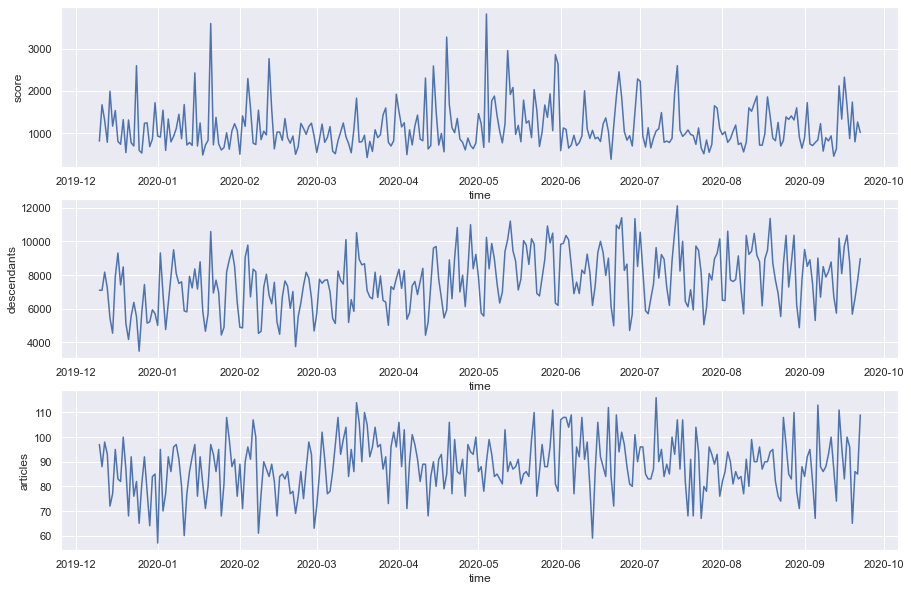

In [21]:
vis.drawing_time_series(score_series, comments_series, articles_series)

It looks much better. We can observe seasonality in our data, so the SARIMA model can be a good pick for that task. To find it out we use seasonal decompose. It provides us more information about our series.

<Figure size 720x576 with 0 Axes>

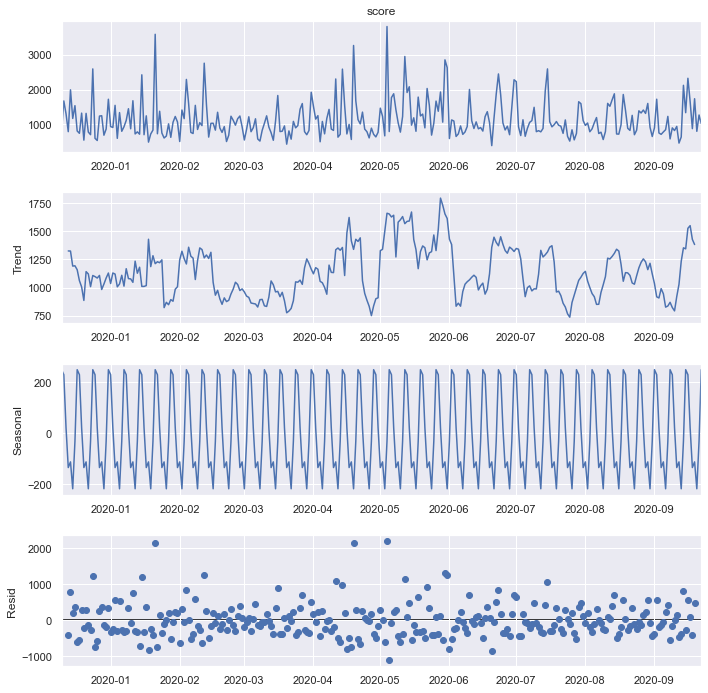

In [22]:
vis.seasonal_decompose_my(score_series)

<Figure size 720x576 with 0 Axes>

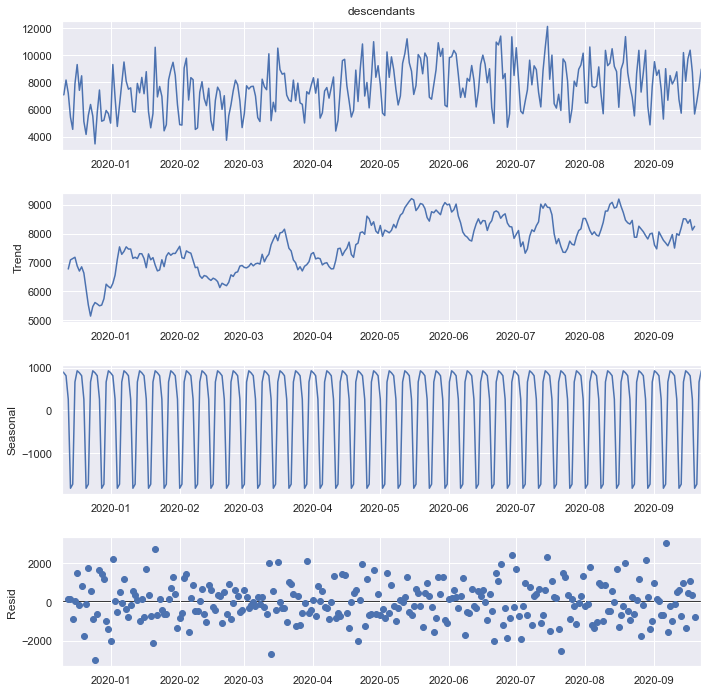

In [23]:
vis.seasonal_decompose_my(comments_series)

<Figure size 720x576 with 0 Axes>

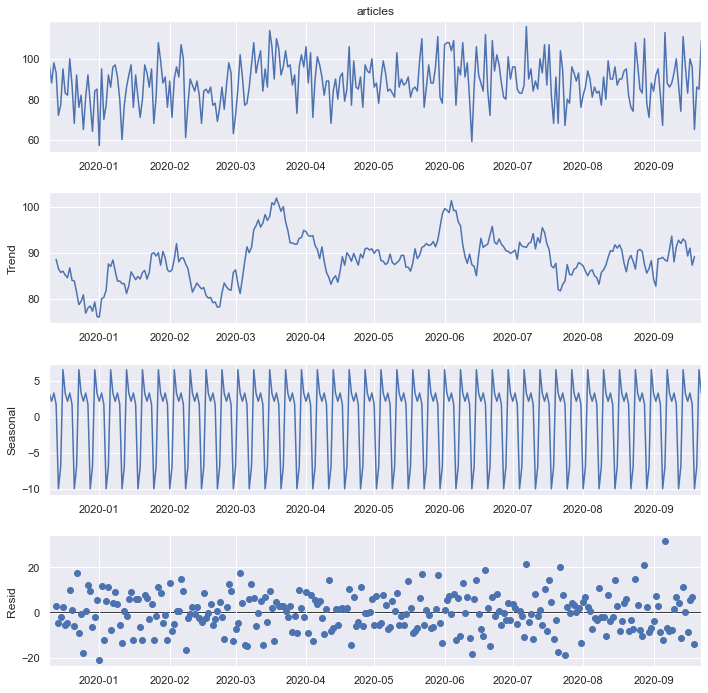

In [24]:
vis.seasonal_decompose_my(articles_series)

### Dickey-Fuller test

We want our time series to be stationary. What does it mean? Previously I said it told us that function doesn't change drastically. In more mathematical way it tell us that:

**1. Mean is constant in time.** <br>
**2. Covariance don't depend on time** 

In exchange of the second argument, we can simpler tell variance is constant in time. This isn't the same as the 2. point but mostly this assumption is desired. One way to examine the stationarity of time series is Dickey-Fuller test and in our case augmented Dickey-Fuller test. This check if time series have an unit root. If yes our data isn't stationary and they probably are in another case. We will look on the p-value returned by function from statsmodels library. But we can also check another measure which delves more in statistics behind test.

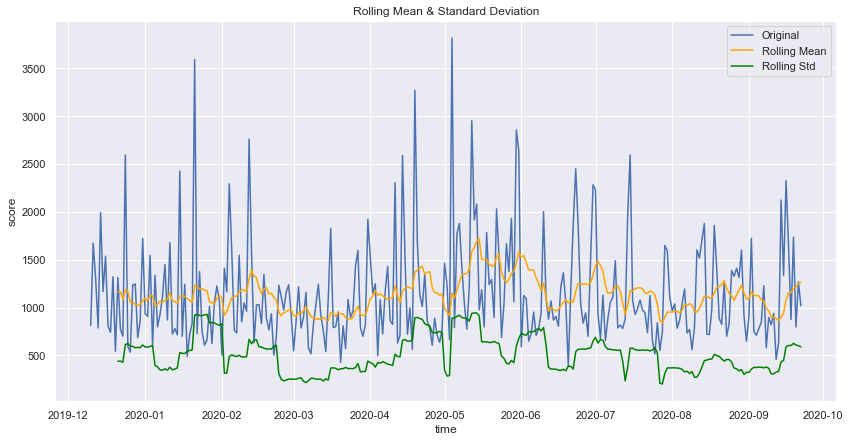

In [25]:
vis.test_stationarity(score_series, 'score')

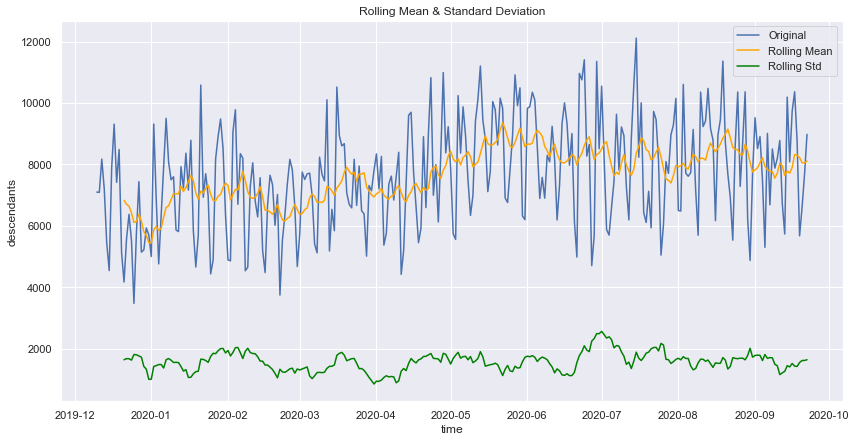

In [26]:
vis.test_stationarity(comments_series, 'comments')

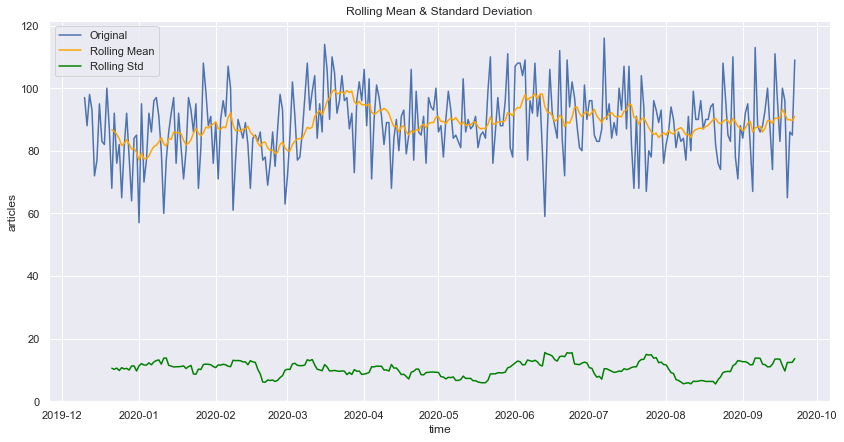

In [27]:
vis.test_stationarity(articles_series, 'articles')

As we can see only the score time-series passed the test, what is very surprising to me because visually it changes mostly over time. But it is hard to argue with pure math. We have to transform somehow our data to achieve stationarity. There are multiple solutions like taking the log or square roots from our data. Because we use ARIMA, the I argument comes from integrating, which in this case means the difference between consecutive elements. Because our data are positive, I tend to combine logarithm with difference. It often gives desired result.

##  Data Transformation

Let's start with the logarithm of score time series. Oddly enough, our test returned a bit worse result than before, but as we can see on plot we flattened deviations which are pretty good. Despite the worse result I feel that it will be better to remain this option.

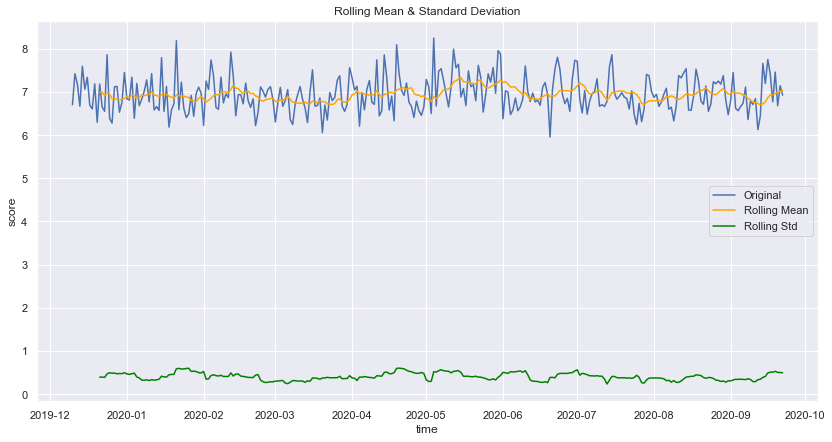

In [28]:
vis.test_stationarity(np.log(score_series), 'score')

Let's check if making a difference from log can improve stationarity.

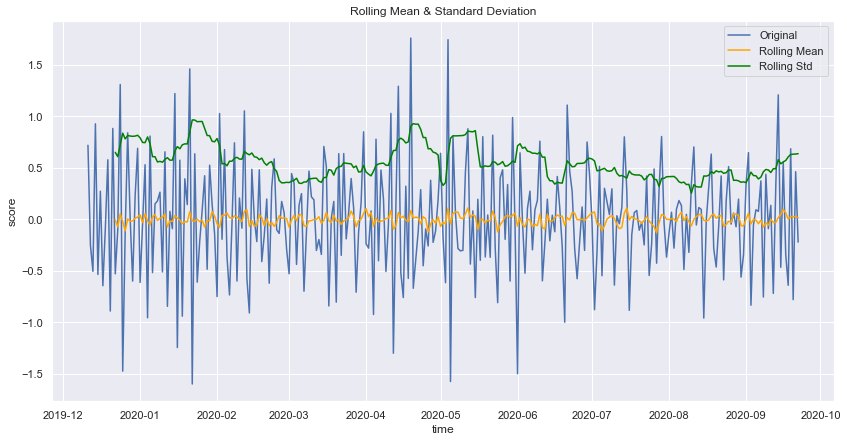

In [29]:
vis.test_stationarity(np.log(score_series).diff().dropna(), 'score')

Finally, that is what we expected. Let's check another time series

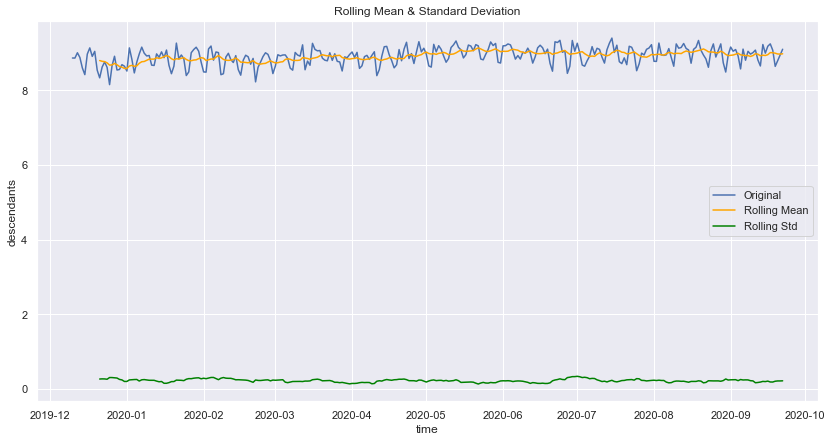

In [30]:
vis.test_stationarity(np.log(comments_series), 'descendants')

As we can see, it improve it a bit but it still isn't stationary, perhaps a square root can do a better job?

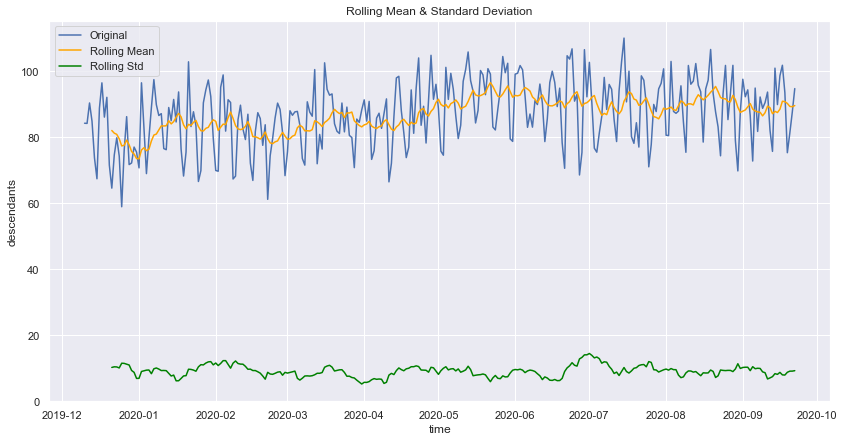

In [31]:
vis.test_stationarity(comments_series**(1/2), 'descendants')

Much worse than in the beginning. What if we conduct difference?

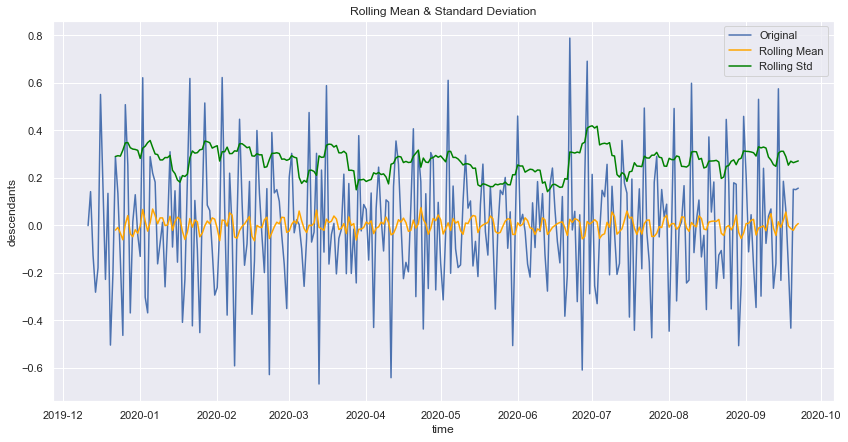

In [32]:
vis.test_stationarity(np.log(comments_series).diff().dropna(), 'descendants')

Pretty good, finally let's transform article series already with difference.

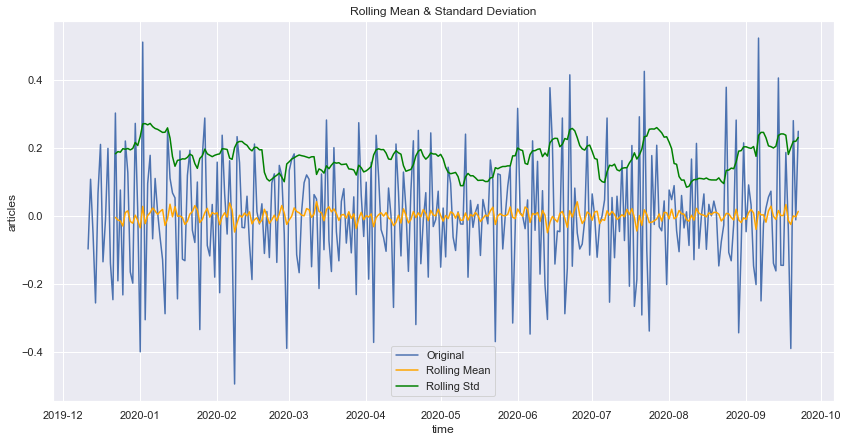

In [33]:
vis.test_stationarity(np.log(articles_series).diff().dropna(), 'articles')

In [34]:
log_score_series = np.log(score_series)
log_comments_series = np.log(comments_series)
log_articles_series = np.log(articles_series)

Ok, we received necessary form of data. The only thing that's left is modeling.

# Sarima modeling

Let's begin with ARMA model. AR is auto-regressive and MA is from moving average. AR describes relation between current observation and all before. MA describes errors caused to current moment by all before. In this moment we want to find two parameters. 

ARMA(*p*, *q*), where 
- *p* - number of past observations dependent with current observation
- *q* - number of past errors dependent with the current observation

So *p* is connected with AR model and *q* with MA. In ARIMA as I said before *I* states from integrated. It gives one additional parameter *d* which is number of consecutive differences. We show before the case when *d* = 1. But if we wanted to continue with subtraction the *d* would increase. So we can add to our list.

- *d* - number of consecutive subtraction

We move now to SARIMA model. S come from seasonal which gives us some intuition. We delve deeper to relations between variables and discover some periodicity. From the seasonal decompose present before we observe the period will be 7 days. SARIMA add 4 more parameters which correspond with the previously.

- *P* - seasonal AR order
- *Q* - seasonal MA order
- *D* - seasonal Integrated order
- *m* - the duration of tge single period

So in our case *m* probably will be 7. Hence finally, we can write down our needed model as.

SARIMA(*p*, *d*, *q*)x(*P*, *D*, *Q*)*m* 

### ACF and PACF plots

A great tool to determine SARIMA parameters are ACF and PACF plots.

- ACF (autocorrelation function) - describes dependency between i-th element and the elements to the i-th moment.<br>
- PACF (partial autocorrelation function) - describes dependency between i-th element and only j-th element. 

There are some rules of thumbs to determine from them the value of *p*, *q*, *P* and *Q*. 
- *p* - we calculate the number of lags above confidence interval in PACF. ACF should cut out to 0
- *q* - ACF is smoothly decreasing to 0. PACF cut out when ACF begin converge.
- *P*, *Q* are analogous but with slight modification to plot. We measure lags every m-th lag.

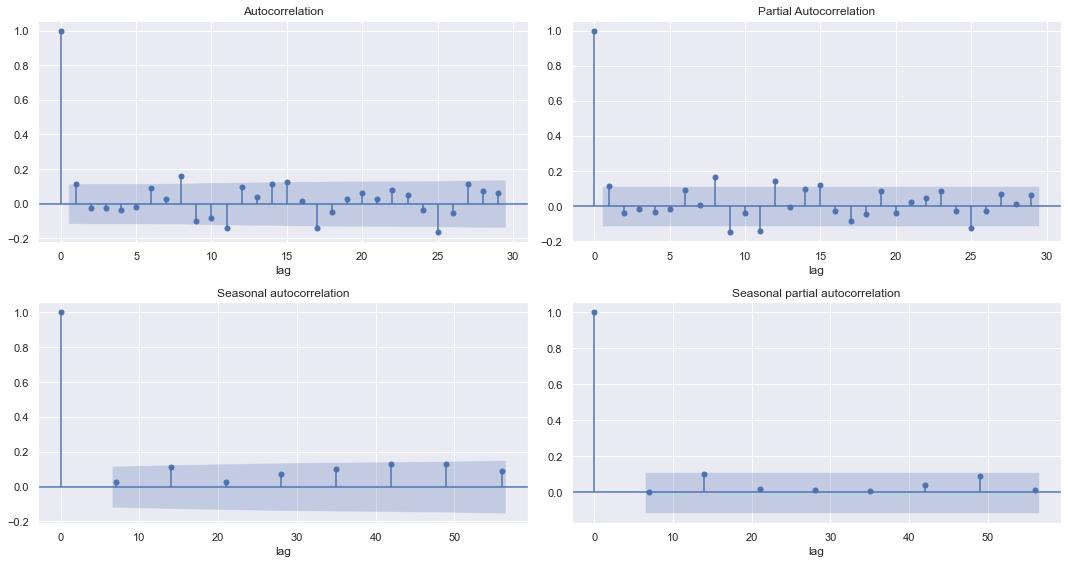

In [35]:
vis.plot_acf_pacf(log_score_series)

From the autocorrelation plot we can hardly tell if any lag has given significant error on present observation so *q* is perhaps 0 or 1. From partial also, we can't really tell which *p* it will be. Perhaps it will be 0, 1 or 2.
From seasonal ACF and seasonal PACF seems that *P*=0 and *Q*=0. From conducted adf tests before we conclude that *d* = 1 because it indeed improves stationarity and perhaps *D*=0 because we endeavour to as simple model as we can.

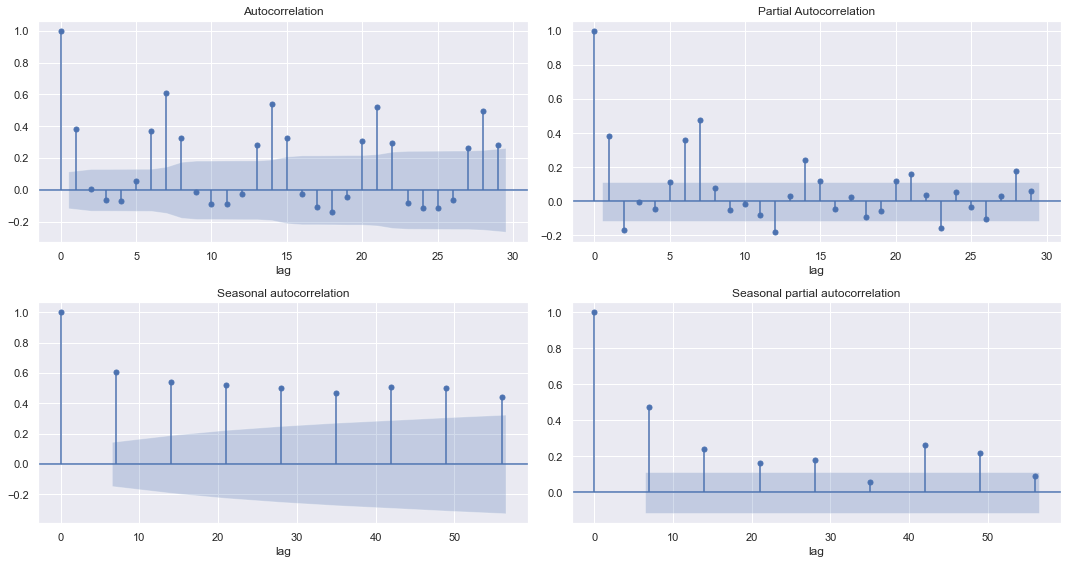

In [36]:
vis.plot_acf_pacf(log_comments_series)

The situation is more complex now. Series is definitely stationary. From the autocorrelation plot we can assume that *q* is perhaps 1 and from partial autocorrelation *p* probably is also 1. Below we can see that from seasonal ACF it is hard to tell what value have *Q* after seeing seasonal PACF it probably will be 3 and *P* will be 3 or 4. The other parameters *d* is 1 and perhaps *D* should also be 1 because we have complexity on seasonality.

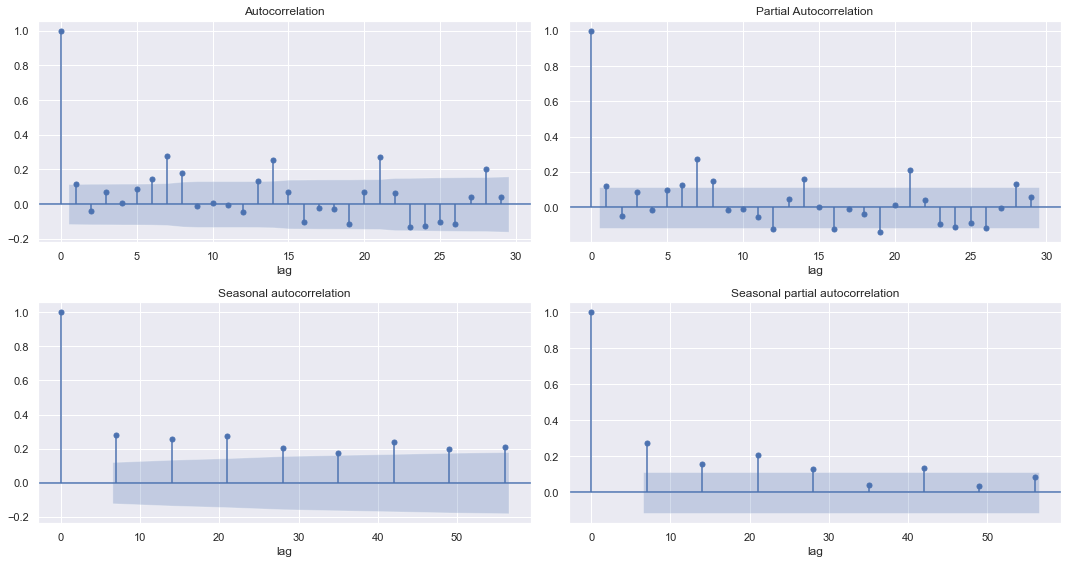

In [37]:
vis.plot_acf_pacf(log_articles_series)

Finally, I think that mostly seasonality matters so I would tell from first view that *p*=0 and *q*=0. From the seasonal part it is hard to tell but perhaps *Q*=3 and *P*=2. *d* still will be 1 and *D* also 1. 

### Information criterions and cross-validation

As we can see from examples above acf and pacf are some tools but they are very hard to interpret and awfully difficult to automate. This process involves a person to analyze them. Because that we want to optimize this task. We use for that purpose information criterions. We focus on AIC and BIC. 

- AIC (Akaike information criterion) is a measure to choose the best model for our problem. As the value of AIC grows as
     the value log-likelihood function also grows and complexity of the model decreases. 
- BIC (Bayesian information criterion) also choose parameters for our model. As it grows it also maximalize log-likelihood function and decrease complexity of the model but it include also the amount of data used for our problem.

It is said that with the AIC criterion prediction are more precise so we use it will have the main vote of choosing the right model.

We have to provide a grid of parameters and perform cross-validation to choose the best models considering AIC as the criterion. For that purpose we will use *auto_arima* function from pmdarima library. It should return the best fitted model to our data. Let's check if my assumption were right.

In [38]:
score_model = auto_arima(log_score_series, start_p=0, start_q=0, max_d=3,
                         start_P=0, start_Q=0, max_D=3,
                         max_P=4, max_Q=4, max_order=10, 
                         m=7, maxiter=150)

score_model

ARIMA(maxiter=150, order=(0, 0, 1), scoring_args={},
      seasonal_order=(0, 0, 0, 7))

In [39]:
comments_model = auto_arima(log_comments_series, start_p=0, start_q=0, max_d=3,
                         start_P=0, start_Q=0, max_D=3,
                         max_P=4, max_Q=4, max_order=10, 
                         m=7, maxiter=150)

comments_model

ARIMA(maxiter=150, order=(0, 1, 1), scoring_args={},
      seasonal_order=(0, 0, 1, 7))

In [40]:
articles_model = auto_arima(log_articles_series, start_p=0, start_q=0, max_d=3,
                         start_P=0, start_Q=0, max_D=3,
                         max_P=4, max_Q=4, max_order=10, 
                         m=7, maxiter=150)

articles_model

ARIMA(maxiter=150, order=(0, 1, 1), scoring_args={},
      seasonal_order=(0, 0, 4, 7), with_intercept=False)

As we can see some of the parameters, we guessed correctly but not always, and it shows that indeed we can use ACF and PACF plots but it could be difficult to obtain optimal solution. Because cross-validation used above is computationally expensive we define models directly from SARIMAX class using above results.

In [41]:
model = SARIMAX(log_score_series, order=(0, 0, 1), seasonal_order=(0, 0, 0, 7))
score_model = model.fit()

model = SARIMAX(log_comments_series, order=(0, 1, 1), seasonal_order=(0, 0, 1, 7))
comments_model = model.fit()

model = SARIMAX(log_articles_series, order=(0, 1, 1), seasonal_order=(0, 0, 4, 7))
articles_model = model.fit()

Before carrying out forecasting lets plot diagnostic to check how well our model corresponds to theory.

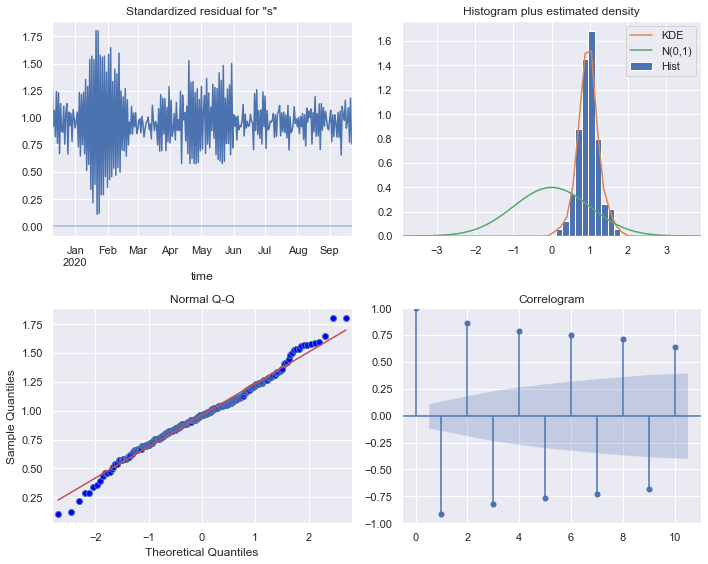

In [42]:
score_model.plot_diagnostics()
plt.tight_layout()
plt.show()

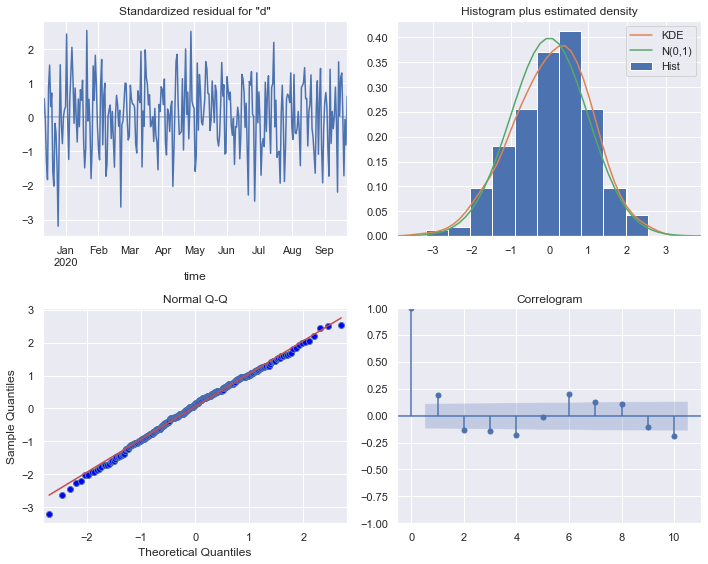

In [43]:
comments_model.plot_diagnostics()
plt.tight_layout()
plt.show()

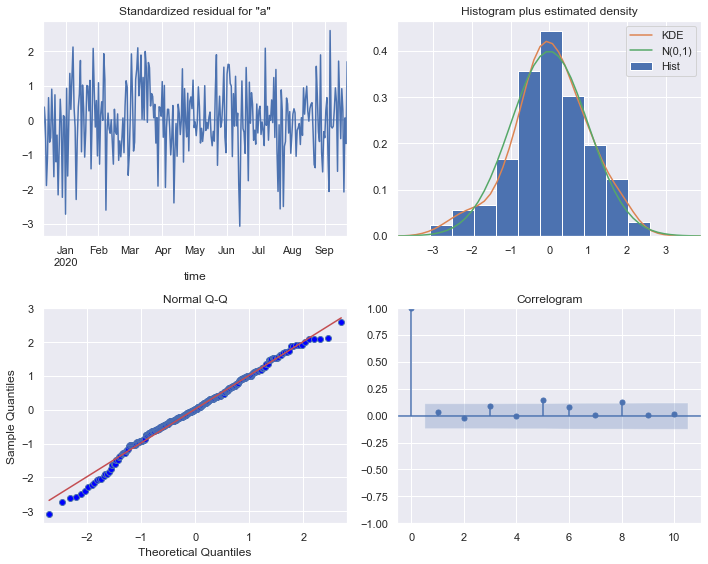

In [44]:
articles_model.plot_diagnostics()
plt.tight_layout()
plt.show()

As we can see SARIMA's theoretical assumption in articles and comments series are mostly fulfilled. Our residuas are independent and normal distributed with mean equal to zero. The problem is with score series, the mean of residuals is shifted as the whole distribution. It comes from the fact that for other series we specify *d* to 1 which resulted in the mean equal to 0. SARIMAX class in default don't include the trend in our time series, but in score series such a trend occurs. Let's remove it.

In [45]:
model = SARIMAX(log_score_series, order=(0, 0, 1), seasonal_order=(0, 0, 0, 7), trend='c')
score_model = model.fit()

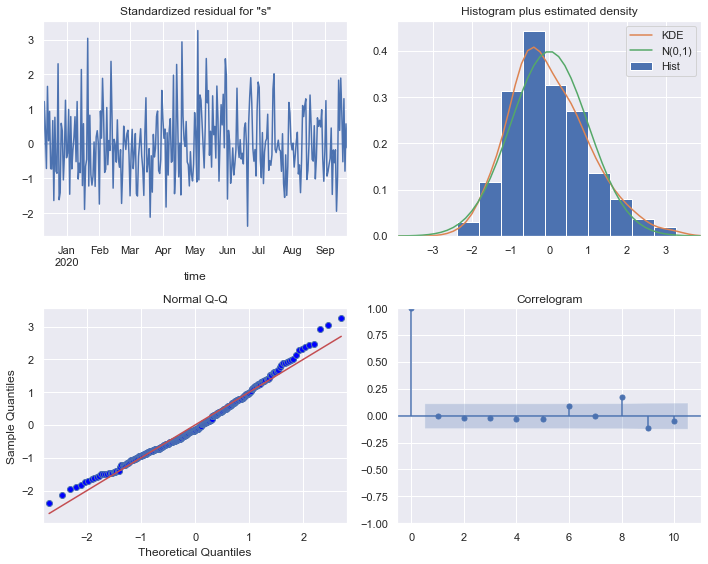

In [46]:
score_model.plot_diagnostics()
plt.tight_layout()
plt.show()

Now it looks much better. It still isn't perfect, but it probably comes from complexity of our model. It is time to plot forecasts of our models.

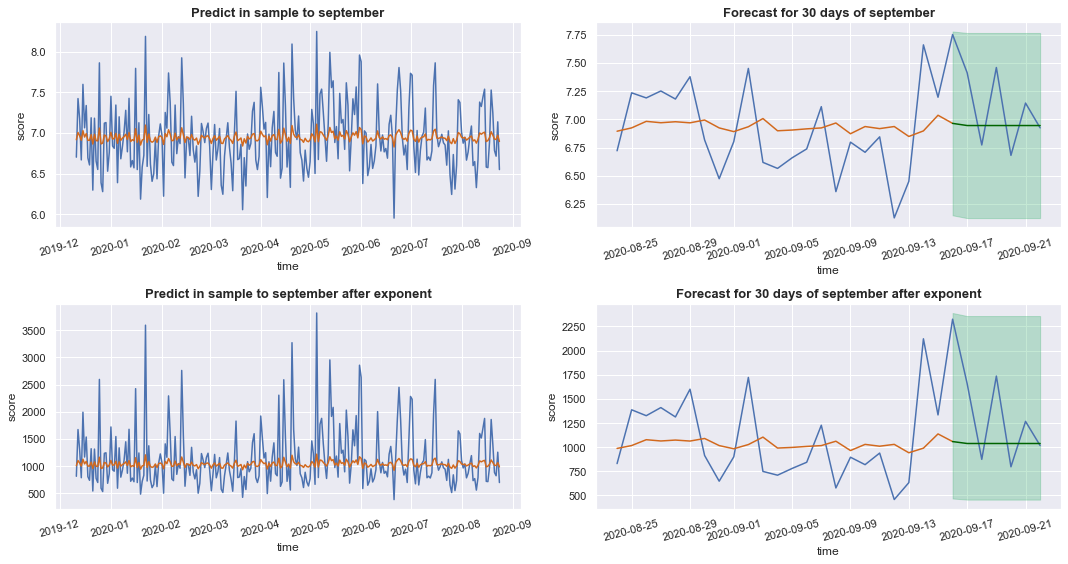

In [47]:
vis.plot_forecast(score_model, log_score_series)

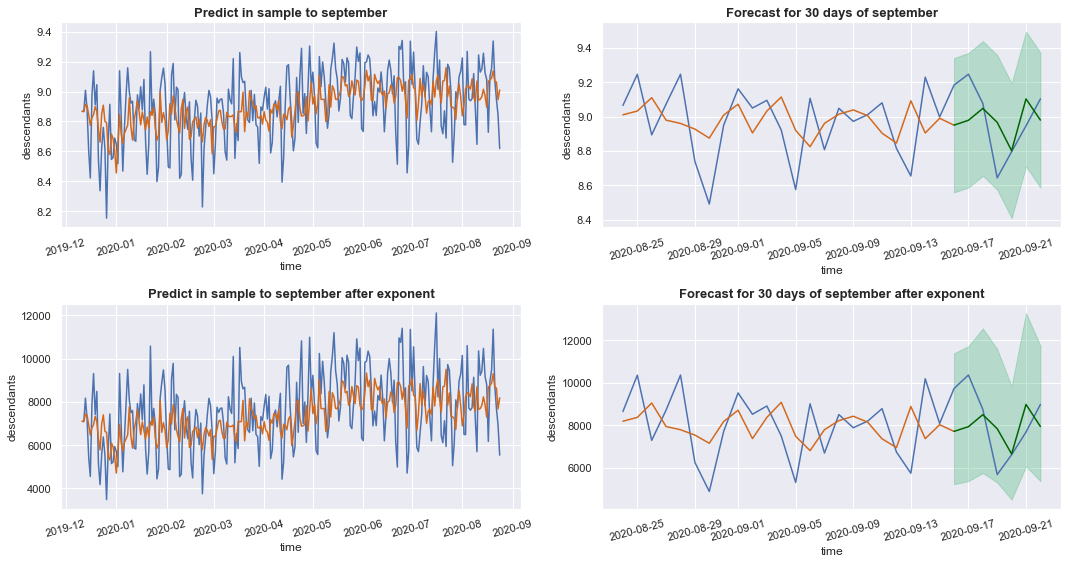

In [48]:
vis.plot_forecast(comments_model, log_comments_series)

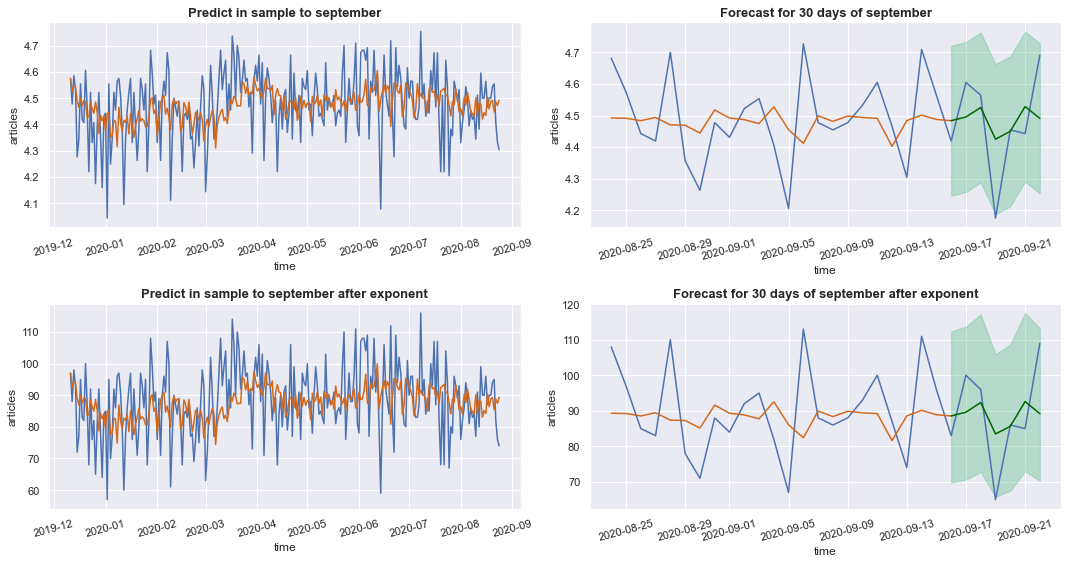

In [49]:
vis.plot_forecast(articles_model, log_articles_series)

The forecasting of number of comments look best. After that a bit worse is number of articles prediction, which couldn't detect such fluctuations and at the very end is prediction of the score which fit almost a line. It looks bad but this is model which we choose so perhaps it could give desired result. So now we predict our time series for 25 September and save results. 

In [50]:
score_pred = score_model.get_prediction('2020-09-25', dynamic=True).predicted_mean
comments_pred = comments_model.get_prediction('2020-09-25', dynamic=True).predicted_mean
articles_pred = articles_model.get_prediction('2020-09-25', dynamic=True).predicted_mean

result = pd.concat([score_pred, comments_pred, articles_pred], axis=1)
result.columns = ['Score', 'Comments', 'Articles']
result = np.exp(result)
result

Score     Comments  Articles
2020-09-25  1038.13481  8043.393605   90.7006

So finally our model on 25th September predict 1038 scores,  8043 comments and 90 new articles. Let's check out how it was in real.

# Preparing test data

How do we scrap our data? Hacker news offers special API on their github profile. From that we can extract any post we want if we have its id. We will use scrapy shell to investigate the hacker news service to search those ids. So we begin by opening the page from 25th September and we will see something like this. 

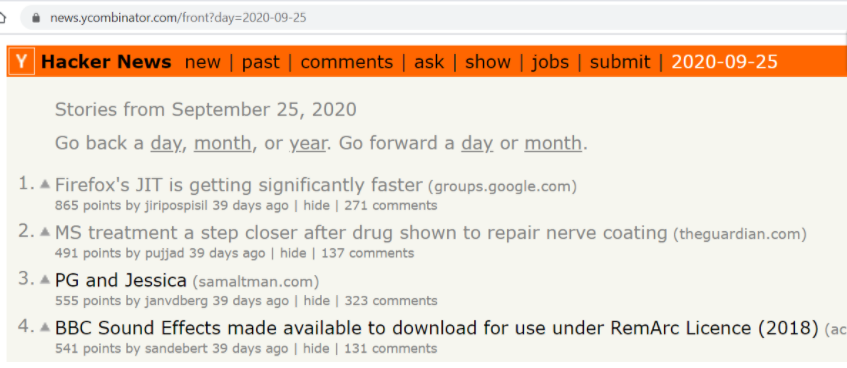

Now we click inspect on first post and see how the html class for it looks like. It should be like this:

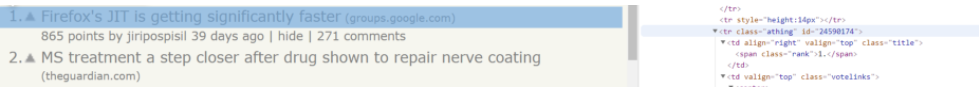

We open in command a scrapy shell with following link and choose id attribute. We use getall method to extract every id on this page. Then we save the result to list.

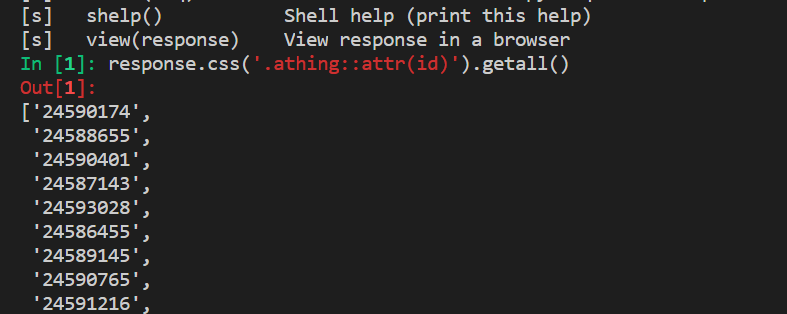

In [51]:
id = ['24585029','24589842', '24593719', '24588920',  '24588795', '24594374', '24590359', '24565505', '24589406', '24589417', '24583385', '24593074', '24589043', '24590965', '24592406', '24565259', '24584400', '24585986', '24586239', '24590499', '24589597', '24565930', '24591454', '24585647', '24565022', '24586556', '24588947', '24589474', '24588523', '24579539', '24588832', '24594833', '24591748', '24572359', '24589261', '24591612', '24593465', '24588442', '24586991', '24590771', '24588453', '24590820', '24590487', '24590589', '24591680', '24590174', '24588655', '24590401', '24587143', '24593028', '24586455', '24589145', '24590765', '24591216', '24591595', '24593616', '24586390', '24591422', '24585478', '24586708', '24587642', '24588853', '24590896', '24588056', '24588856', '24587934', '24581360', '24591131', '24586436', '24588913', '24593343', '24583109', '24593570', '24590685', '24576865']

Now when we have id list, we will use request library and via hacker news's API download json files. The API looks like below.

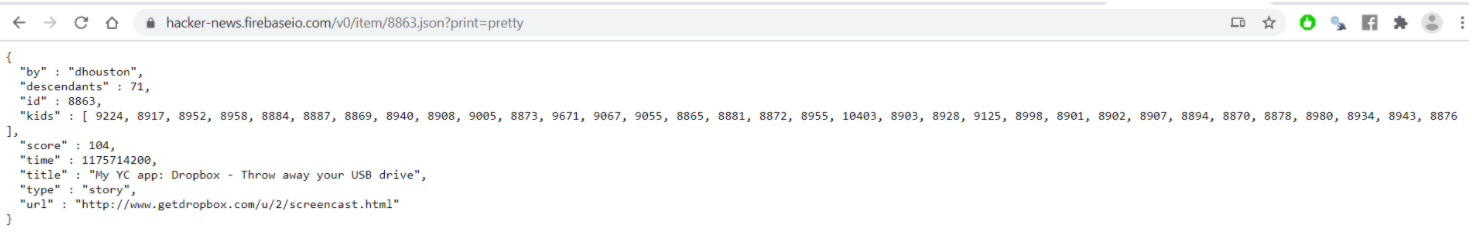

We store everything in single data frame.

In [52]:
test = pd.DataFrame({}, columns=df.columns)

for i in id:
    r = requests.get('https://hacker-news.firebaseio.com/v0/item/{}.json'.format(i))
    unit = r.json()
    test = test.append(unit, ignore_index=True)

In [53]:
test.head()

by descendants        id  \
0  mrfusion         252  24585029   
1   osazuwa          90  24589842   
2  bitigchi          15  24593719   
3  samizdis         173  24588920   
4  tomohawk         111  24588795   

                                                kids score        time  \
0  [24585548, 24585570, 24585516, 24585520, 24585...   108  1600991496   
1  [24590586, 24590438, 24590416, 24590303, 24590...    74  1601042859   
2                     [24594375, 24596710, 24597410]    34  1601065173   
3  [24589426, 24589954, 24589611, 24589742, 24589...    62  1601036113   
4  [24589883, 24590161, 24589950, 24589923, 24589...    66  1601034455   

                                               title   type  \
0  Boulder prohibits gatherings of any size for 1...  story   
1  How poker and a spaceship imposter game make y...  story   
2                   Haiku: Contest for System Sounds  story   
3  Belief in Conspiracy Theories Is a Barrier to ...  story   
4  Watch a Tesla Fail an Automatic Braking Test a...  story   

                                                 url text  
0  https://247sports.com/college/colorado/Article...  NaN  
1  https://altdeep.substack.com/p/how-poker-and-a...  NaN  
2  https://www.haiku-os.org/news/2020-09-11-syste...  NaN  
3  https://www.annenbergpublicpolicycenter.org/be...  NaN  
4  https://www.thedrive.com/tech/36649/watch-a-te...  NaN

And now we have to extract required informations. First, of all lets convert time column from Timestamp to date format.

In [54]:
test['time'] =  pd.to_datetime(test['time'], unit='s')

After that we should resample our data frame by day and compute our test data.

In [55]:
score_test = test[['score', 'time']].resample('D', on='time').max()
score_25th = score_test.loc['2020-09-25', 'score']

comments_test = test[['descendants', 'time']].resample('D', on='time').sum()
comments_25th = comments_test.loc['2020-09-25', 'descendants']

articles_test = test[['score', 'time']].resample('d', on='time').count()
articles_25th = articles_test.loc['2020-09-25', 'score']

print('On 25th september there was:')
print('Score: ', score_25th)
print('Comments: ', comments_25th)
print('Articles: ', articles_25th)

On 25th september there was:
Score:  865
Comments:  6880
Articles:  63


# Result

Recall that we have to minimize special cost function defined bellow:



$$\Bigg|\frac{n\_articles - pred\_articles}{n\_articles}\Bigg| +\Bigg|\frac{n\_comments - pred\_comments}{n\_comments}\Bigg| +\Bigg|\frac{max\_score - pred\_max\_score}{max\_score}\Bigg|$$

We compute each parameter, so the only thing left is to define this function and input our variables.

In [56]:
def loss_function(n_articles_test, preds_n_articles, n_comments, pred_comments, max_score, pred_score):
    # Creating result data frame
    df = pd.DataFrame({'True value': [n_articles_test, n_comments, max_score],
                       'Predicted value':[preds_n_articles, pred_comments, pred_score],
                       # calculating error
                       'Error':[abs(n_articles_test-preds_n_articles), abs(n_comments-pred_comments),
                                abs(max_score-pred_score)], 
                       # calculating error rate
                       'Error rate':[abs(n_articles_test-preds_n_articles)/ n_articles_test,
                                      abs(n_comments-pred_comments)/n_comments,
                                      abs(max_score-pred_score)/max_score]})
    df.index = ['Articles', 'Comments', 'Score']
    # returning dataframe and result
    return df, abs(n_articles_test-preds_n_articles)/n_articles_test + \
            abs(n_comments-pred_comments)/n_comments + \
            abs(max_score-pred_score)/max_score 

In [57]:
loss_frame, loss_result = loss_function(articles_25th, result.iloc[0, 2], comments_25th, result.iloc[0, 1], score_25th, result.iloc[0, 0])

In [58]:
loss_frame

True value  Predicted value        Error  Error rate
Articles          63        90.700600    27.700600    0.439692
Comments        6880      8043.393605  1163.393605    0.169098
Score            865      1038.134810   173.134810    0.200156

As we can see our predictions stand off from the real values but we could infer that from forecast plots. The greatest error comes from comments and the smallest from articles. It is apparent because from error rate column we can see that prediction of articles contribute more error than other features both together. The final result is about 0.8 and its hard to interpret because we haven't any other solution to compare, but from my opinion it could be better. SARIMA clearly was to simple model for this task.

In [59]:
loss_result

0.8089458272823583

# Conclusion

This was the warm up challenge from the Why R? hackathon. I pick up this project because it was a task from the scientific club to expand our abilities in time series analysis. It is hard to say if such a model to predict daily activities on service could be useful for hacker news service. Perhaps they could use it to present some investors popularity of the website in the future. On the other hand they can track the trend of activities and if it will decrease they can somehow prevent it.

From the get to go it was obvious that it will be a time-series analysis problem, but it was difficult to come to ide how to handle prediction of three variables. We had to minimalize loss function which required 3 forecasts. How to model it? Which model should I choose without any experience on this field? Are my data okay and how can I check this? Perhaps they should be more suited to such a problem? Which metrics should I choose to measure model performance? How will I get my test data, they weren't provided by Why R? Institution.

I don't even remember how I come up with the idea of modelling 3 time series but it was a great pick. As I read the group, who won those challenge had the same approach, but unfortunately I couldn't find their result. It was difficult to solve problem of our data, because I pick up this task after It was held and from that my solution could deviate a bit from reality. We had to assume they are real. It was necessary to remove outliers on boundaries and then make our series stationary. We used augmented Dickey-Fuller test to check if they were stationary and then transform them with the logarithm to obtain it. We decided to use SARIMA model which is a bit more complex than standard ARMA models, but as it was my first contact with such a problem it looks good for me. We tried choosing parameters of a model by looking at ACF and PACF plots at the beginning but it was difficult so we have to rely on AIC criterion and SARIMA cross-validation. 
We check the results visually and they weren't as good as we could imagine it. Perhaps SARIMA was to simple model for that problem. Prediction couldn't catch drastic deviations from data. Everything was for learning purposes, so it was ok. After that we had to scrape data from website with scrapy shell and requests library. And finally we obtain result.

For my opinion it could be better but it was an introductionary project so it has on purpose to learn basic elements of time-series analysis. We had to get familiar with series transformations statistics test and modeling. SARIMA couldn't obtain a good result because of low order or low complexity. It underfitted. Perhaps we couldn't won that hackathon but definitely we could have fun from comparing with others.